<a href="https://colab.research.google.com/github/Abdullah-M-Alrefai/Ai_email_filter/blob/main/Ai_WorkShop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **AI-Powered Content Classification and Sentiment Analysis.**

This notebook presents a step-by-step guide to building an efficient Email spam classification model using the email Spam Collection dataset. By the end of this notebook, you'll have a powerful tool to help you filter out unwanted email messages and ensure that your email messaging experience is smoother and safer. 🙂

In [1]:
# Install required package
!pip install lime
# Import necessary libraries
import os
import re
import string
import numpy as np
import pandas as pd
import shap
import lime
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from google.colab import files
# Machine Learning Libraries
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve

# TensorFlow Libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
# Upload dataset
uploaded = files.upload()
df = pd.read_csv(next(iter(uploaded)), encoding='latin-1')  # or 'cp1252', 'iso-8859-1', etc.

Saving email_spam.csv to email_spam (17).csv


In [3]:
# Display basic dataset info
print(df.info())
print(df.head())
df.describe()
df.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80 entries, 0 to 79
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   80 non-null     object
 1   text    80 non-null     object
 2   type    80 non-null     object
dtypes: object(3)
memory usage: 2.0+ KB
None
                                               title  \
0                          ?? the secrets to SUCCESS   
1                    ?? You Earned 500 GCLoot Points   
2                         ?? Your GitHub launch code   
3  [The Virtual Reward Center] Re: ** Clarifications   
4  10-1 MLB Expert Inside, Plus Everything You Ne...   

                                                text      type  
0  Hi James,\n\nHave you claim your complimentary...      spam  
1  \nalt_text\nCongratulations, you just earned\n...      spam  
2  Here's your GitHub launch code, @Mortyj420!\n ...  not spam  
3  Hello,\n \nThank you for contacting the Virtua...  not spam  
4  Hey Prac

(80, 3)

In [4]:
## Text Preprocessing
def clean_text(text):
    if isinstance(text, str):
        text = text.lower()
        text = re.sub(f"[{string.punctuation}]", "", text)
        return text
    return ""

df.dropna(inplace=True)  # Drop missing values
df['text'] = df['title'] + ' ' + df['text']  # Combine title and text
df['text'] = df['text'].apply(clean_text)
df['label'] = df['type'].apply(lambda x: 1 if x == 'spam' else 0)

In [5]:
# Split dataset
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['label'], test_size=0.2, random_state=42, stratify=df['label'])

In [6]:
# Convert labels to numerical values
df['label'] = df['type'].apply(lambda x: 1 if x == 'spam' else 0)
print(df.head())

                                               title  \
0                          ?? the secrets to SUCCESS   
1                    ?? You Earned 500 GCLoot Points   
2                         ?? Your GitHub launch code   
3  [The Virtual Reward Center] Re: ** Clarifications   
4  10-1 MLB Expert Inside, Plus Everything You Ne...   

                                                text      type  label  
0   the secrets to success hi james\n\nhave you c...      spam      1  
1   you earned 500 gcloot points \nalttext\ncongr...      spam      1  
2   your github launch code heres your github lau...  not spam      0  
3  the virtual reward center re  clarifications h...  not spam      0  
4  101 mlb expert inside plus everything you need...      spam      1  


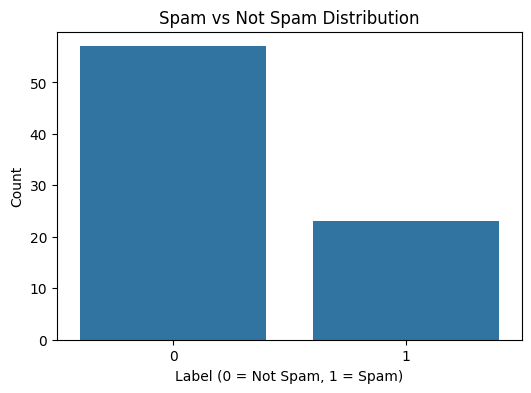

In [7]:
# Visualization: Spam vs. Not Spam Distribution
plt.figure(figsize=(6, 4))
sns.countplot(x=df['label'])
plt.title('Spam vs Not Spam Distribution')
plt.xlabel('Label (0 = Not Spam, 1 = Spam)')
plt.ylabel('Count')
plt.show()


In [8]:
# Convert text to numerical features using TF-IDF
vectorizer = TfidfVectorizer(stop_words='english', max_features=10000)
X_train_tfidf = vectorizer.fit_transform(X_train).toarray()
X_test_tfidf = vectorizer.transform(X_test).toarray()

In [9]:
# Handle Class Imbalance with SMOTE
smote = SMOTE(random_state=42)
X_train_tfidf, y_train = smote.fit_resample(X_train_tfidf, y_train)

In [10]:
# Get most common words for spam and real emails
# First, create spam_emails and real_emails lists by filtering the DataFrame
spam_emails = df[df['label'] == 1]['text'].tolist()
real_emails = df[df['label'] == 0]['text'].tolist()

from collections import Counter  # Import Counter

spam_words = ' '.join(spam_emails).split()
real_words = ' '.join(real_emails).split()

spam_common = [word for word, count in Counter(spam_words).most_common(20)]
real_common = [word for word, count in Counter(real_words).most_common(20)]

In [11]:
# Define a more complex model
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_tfidf.shape[1],), kernel_regularizer=l2(0.01)),
    Dropout(0.5),
    Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 360ms/step - accuracy: 0.4353 - loss: 3.8766 - val_accuracy: 0.5000 - val_loss: 3.5373


Saved epoch_model_1.h5
Best model updated: best_epoch_model.h5
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 254ms/step - accuracy: 0.6403 - loss: 3.4502 - val_accuracy: 0.4375 - val_loss: 3.1570


Saved epoch_model_2.h5
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 252ms/step - accuracy: 0.7461 - loss: 3.0751 - val_accuracy: 0.4375 - val_loss: 2.8226


Saved epoch_model_3.h5
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 254ms/step - accuracy: 0.7024 - loss: 2.7517 - val_accuracy: 0.5000 - val_loss: 2.5303


Saved epoch_model_4.h5
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 224ms/step - accuracy: 0.7576 - loss: 2.4633 - val_accuracy: 0.5625 - val_loss: 2.2770


Saved epoch_model_5.h5
Best model updated: best_epoch_model.h5
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.8217 - loss: 2.2132 - val_accuracy: 0.6875 - val_loss: 2.0595


Saved epoch_model_6.h5


Best model updated: best_epoch_model.h5
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 0.9088 - loss: 1.9985 - val_accuracy: 0.7500 - val_loss: 1.8736


Saved epoch_model_7.h5
Best model updated: best_epoch_model.h5
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 246ms/step - accuracy: 0.9361 - loss: 1.8121 - val_accuracy: 0.6875 - val_loss: 1.7147


Saved epoch_model_8.h5
Epoch 9/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 277ms/step - accuracy: 0.9665 - loss: 1.6577 - val_accuracy: 0.6875 - val_loss: 1.5804


Saved epoch_model_9.h5
Epoch 10/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 325ms/step - accuracy: 0.9704 - loss: 1.5241 - val_accuracy: 0.7500 - val_loss: 1.4662


Saved epoch_model_10.h5
Epoch 11/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 421ms/step - accuracy: 0.9626 - loss: 1.4051 - val_accuracy: 0.7500 - val_loss: 1.3706


Saved epoch_model_11.h5
Epoch 12/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 216ms/step - accuracy: 0.9828 - loss: 1.3073 - val_accuracy: 0.7500 - val_loss: 1.2903


Saved epoch_model_12.h5
Epoch 13/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.9735 - loss: 1.2237 - val_accuracy: 0.7500 - val_loss: 1.2219


Saved epoch_model_13.h5
Epoch 14/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 270ms/step - accuracy: 1.0000 - loss: 1.1478 - val_accuracy: 0.7500 - val_loss: 1.1643


Saved epoch_model_14.h5
Epoch 15/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 231ms/step - accuracy: 1.0000 - loss: 1.0892 - val_accuracy: 0.7500 - val_loss: 1.1154


Saved epoch_model_15.h5
Epoch 16/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 275ms/step - accuracy: 1.0000 - loss: 1.0228 - val_accuracy: 0.7500 - val_loss: 1.0730


Saved epoch_model_16.h5
Epoch 17/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 262ms/step - accuracy: 1.0000 - loss: 0.9616 - val_accuracy: 0.7500 - val_loss: 1.0356


Saved epoch_model_17.h5
Epoch 18/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step - accuracy: 1.0000 - loss: 0.9085 - val_accuracy: 0.7500 - val_loss: 1.0043


Saved epoch_model_18.h5
Epoch 19/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 353ms/step - accuracy: 1.0000 - loss: 0.8605 - val_accuracy: 0.7500 - val_loss: 0.9752


Saved epoch_model_19.h5
Epoch 20/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 347ms/step - accuracy: 1.0000 - loss: 0.8004 - val_accuracy: 0.7500 - val_loss: 0.9491


Saved epoch_model_20.h5


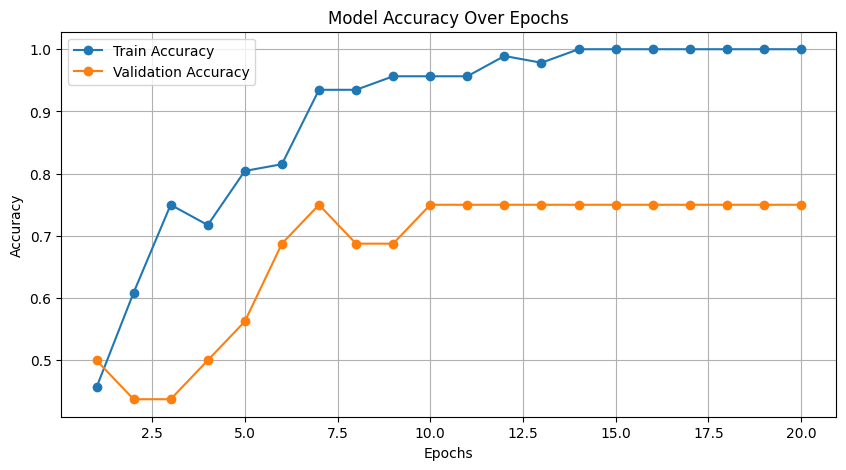

In [12]:
# Early Stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train model and save each epoch's model
best_val_accuracy = 0.0
best_model_path = "best_epoch_model.h5"

train_acc = []
val_acc = []

for epoch in range(1, 21):  # Training for 20 epochs
    print(f"Epoch {epoch}/20")

    history = model.fit(
        X_train_tfidf, y_train,
        epochs=1,
        batch_size=32,
        validation_data=(X_test_tfidf, y_test),
        verbose=1,
        callbacks=[early_stopping]  # Added early stopping here
    )

    # Store accuracy values
    train_acc.append(history.history['accuracy'][0])
    val_acc.append(history.history['val_accuracy'][0])

    model_path = f"epoch_model_{epoch}.h5"
    model.save(model_path)
    print(f"Saved {model_path}")

    if history.history['val_accuracy'][0] > best_val_accuracy:
        best_val_accuracy = history.history['val_accuracy'][0]
        model.save(best_model_path)
        print(f"Best model updated: {best_model_path}")

# Visualization: Training History
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_acc) + 1), train_acc, label='Train Accuracy', marker='o')
plt.plot(range(1, len(val_acc) + 1), val_acc, label='Validation Accuracy', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.legend()
plt.grid()
plt.show()

In [13]:
# Evaluate model
y_pred_probs = model.predict(X_test_tfidf)
y_pred = (y_pred_probs > 0.3).astype('int32')  # Lower threshold to capture more spam

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(classification_report(y_test, y_pred))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step
Accuracy: 0.3750
Precision: 0.3333
Recall: 1.0000
F1 Score: 0.5000
              precision    recall  f1-score   support

           0       1.00      0.09      0.17        11
           1       0.33      1.00      0.50         5

    accuracy                           0.38        16
   macro avg       0.67      0.55      0.33        16
weighted avg       0.79      0.38      0.27        16



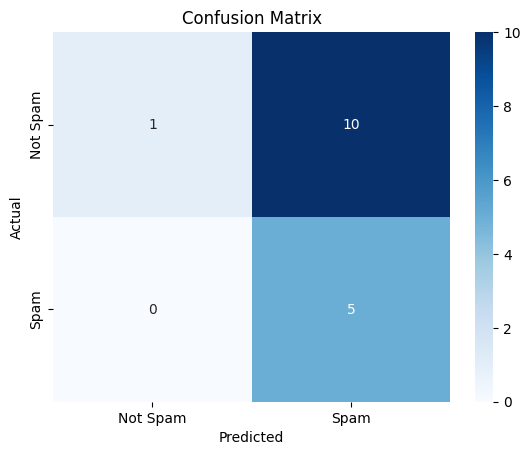

In [14]:
# Visualization: Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Spam', 'Spam'], yticklabels=['Not Spam', 'Spam'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


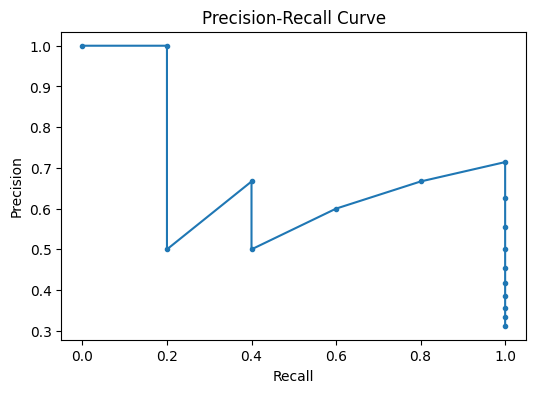

In [15]:
# Visualization: Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_pred_probs)
plt.figure(figsize=(6, 4))
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

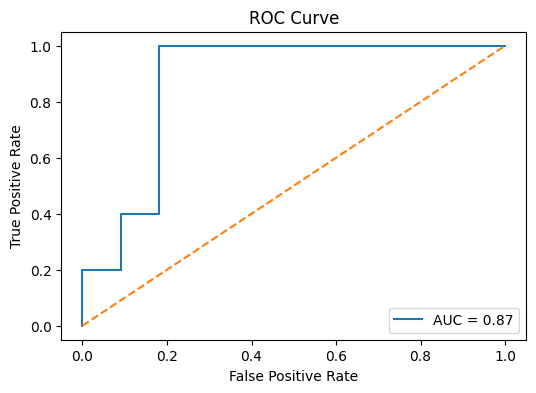

In [16]:
# Visualization: ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_probs)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

In [17]:
def predict_from_csv():
    print("Upload a CSV file with 'title' and 'text' columns for prediction.")
    uploaded_file = files.upload()
    test_df = pd.read_csv(next(iter(uploaded_file)), encoding='latin-1') # Change encoding to 'latin-1' or 'cp1252'

    # Convert 'title' and 'text' columns to string type before combining
    test_df['title'] = test_df['title'].astype(str)
    test_df['text'] = test_df['text'].astype(str)

    test_df['text'] = test_df['title'] + ' ' + test_df['text']  # Combine title and text
    test_tfidf = vectorizer.transform(test_df['text']).toarray()
    predictions = (model.predict(test_tfidf) > 0.5).astype('int32')

    test_df['prediction'] = predictions
    test_df['prediction'] = test_df['prediction'].apply(lambda x: 'Spam' if x == 1 else 'Not Spam')

    test_df[test_df['prediction'] == 'Not Spam'].to_csv('primary_mail.csv', index=False, encoding='utf-8')
    test_df[test_df['prediction'] == 'Spam'].to_csv('junk_mail.csv', index=False, encoding='utf-8')

    print("Prediction results saved to 'primary_mail.csv' and 'junk_mail.csv'.")
    print(test_df[['title', 'text', 'prediction']])
    return test_df

In [18]:
#Run prediction on uploaded CSV
predicted_df = predict_from_csv()


Upload a CSV file with 'title' and 'text' columns for prediction.


Saving test.csv to test (11).csv
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
Prediction results saved to 'primary_mail.csv' and 'junk_mail.csv'.
                                                title  \
0           Congratulations! You won a 1000 gift card   
1       Meeting Reminder: Project discussion tomorrow   
2   Exclusive Offer: Limited-time discount on elec...   
3      Security Alert: Unusual login attempt detected   
4        Final Notice: Your account will be suspended   
5   Invitation: Join our professional networking e...   
6                       Claim Your Free Vacation Now!   
7                                  TIDALs givewaway    
8             Invoice #12345 for your recent purchase   
9           Your bank statement is ready for download   
10     Special Deal: Get 50% off on all subscriptions   

                                                 text prediction  
0   Congratulations! You won a 1000 gift card Clic...       Spam  
1   Meeting Reminder: Project discussion t

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:   6%|▋         | 1/16 [00:00<?, ?it/s]

86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  19%|█▉        | 3/16 [00:13<00:17,  1.31s/it]

56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  25%|██▌       | 4/16 [00:15<00:18,  1.56s/it]

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  31%|███▏      | 5/16 [00:17<00:21,  1.92s/it]

60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  38%|███▊      | 6/16 [00:20<00:21,  2.16s/it]

71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  44%|████▍     | 7/16 [00:22<00:20,  2.27s/it]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  50%|█████     | 8/16 [00:24<00:18,  2.30s/it]

76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  56%|█████▋    | 9/16 [00:27<00:16,  2.36s/it]

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  62%|██████▎   | 10/16 [00:29<00:13,  2.29s/it]

60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  69%|██████▉   | 11/16 [00:31<00:11,  2.31s/it]

146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  75%|███████▌  | 12/16 [00:35<00:11,  2.75s/it]

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  81%|████████▏ | 13/16 [00:38<00:07,  2.64s/it]

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  88%|████████▊ | 14/16 [00:40<00:05,  2.66s/it]

68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer:  94%|█████████▍| 15/16 [00:43<00:02,  2.57s/it]

75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer: 100%|██████████| 16/16 [00:46<00:00,  2.71s/it]

56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


PermutationExplainer explainer: 17it [00:48,  3.01s/it]


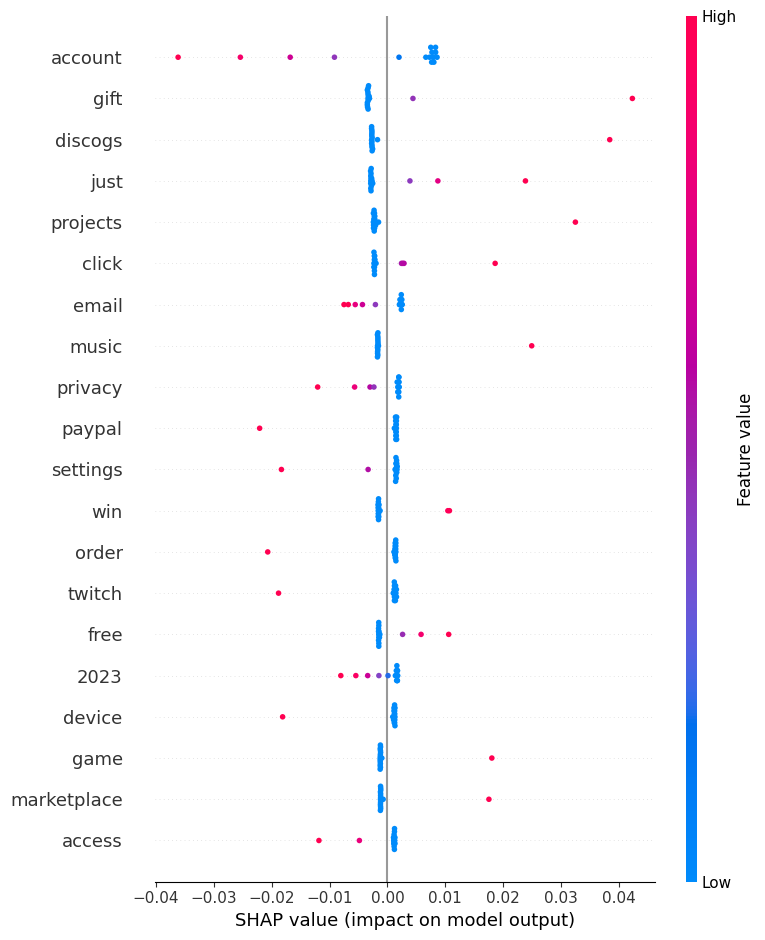

In [19]:
# Visualization: SHAP Interpretability
explainer = shap.Explainer(model.predict, X_test_tfidf)
shap_values = explainer(X_test_tfidf, max_evals=X_test_tfidf.shape[1] * 2 + 1) # Set max_evals to at least 2 * num_features + 1
shap.summary_plot(shap_values, X_test_tfidf, feature_names=vectorizer.get_feature_names_out())

In [20]:
# Visualization: Lime Interpretability
explainer = lime.lime_tabular.LimeTabularExplainer(
    X_train_tfidf,
    feature_names=vectorizer.get_feature_names_out(),
    class_names=['Not Spam', 'Spam'],
    discretize_continuous=True
)
example = X_test_tfidf[0]

# Change model.predict to a function that returns probabilities for both classes
def predict_proba(X):
    probs = model.predict(X)  # Get predictions from your model
    return np.column_stack([(1 - probs), probs]) # Return probabilities for both classes

exp = explainer.explain_instance(example, predict_proba, num_features=10) # Use predict_proba here
exp.show_in_notebook()


157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
